# INFERENCE CODE

In [98]:
import torch

from paperswithtopic.config import load_config
from paperswithtopic.inference import inference, revert2class
import paperswithtopic.inference as inf
from paperswithtopic.preprocess import Preprocess

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(context='notebook', palette='Reds_r')

from IPython.display import clear_output

In [110]:
cfg = load_config('./asset/config.yml')
cfg.output_attentions = True

idx2word = Preprocess(cfg=cfg).load_idx2word()

papers = [
    'Light Gated Recurrent Units for Speech Recognition'
]

model_path = './asset/bertclassification_EP12_VALAUC92.pth'
preds, attn, (paper, mask) = inf._inference(cfg, papers, model_path)

Use cuda:0 as a device.
Load Bertclassification as model.
[remove_unknown] 0.0 sec 
[tokenize_papers] 0.0 sec 
[build_mask] 0.0 sec 
[preprocess_infer] 2.7 sec 
[_inference] 3.3 sec 


In [134]:
 revert2class(preds, cfg)

G:\My Drive\projects\paperswithcode_nlp\paperswithtopic\inference.py:90: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  column2idx = yaml.load(f)


([['speech', 'natural-language-processing', 'audio']],
 [[0.9304340481758118, 0.039524342864751816, 0.00998354610055685]])

# ATTENTION VECTOR

In [111]:
back2word = lambda idxs: list(map(lambda x: idx2word[int(x)], idxs))
attn_lh = lambda attn, layer, head: attn[layer].squeeze()[head]
attn_truncate = lambda attn, idx: attn[:idx, :idx]
attn_filtered = lambda attn, layer, head, idx: attn_truncate(attn_lh(attn, layer, head), idx)
def converter(papers, mask=None, idx=0):
    
    paper = back2word(papers[idx])
    if mask is not None:
        last_idx = int(sum(mask[idx]))
        return paper[:last_idx], last_idx
    
    else:
        return paper

In [112]:
paper, last_idx = converter(paper, mask)

In [141]:
def draw_heatmap(attn, paper, title=None):
    grid_kws = {"height_ratios": (.95, .05), "hspace": .2}

    fig, (ax, cbar_ax) = plt.subplots(2, figsize=(8, 10), gridspec_kw=grid_kws)

    if title is None:
        title = 'Attention Score Heatmap'
    ax.set_title(title, size='large')
    sns.heatmap(attn, xticklabels=paper, yticklabels=paper, linewidths=.55,
                cbar_ax=cbar_ax, fmt=".3f", annot=True, cmap='Reds',
               cbar_kws={"orientation": "horizontal"}, ax=ax)
    return (ax, cbar_ax)

In [128]:
attn_avg_0 = sum(attn_filtered(attn, 0, h, last_idx) for h in range(cfg.n_heads)) / cfg.n_heads
attn_avg_1 = sum(attn_filtered(attn, 1, h, last_idx) for h in range(cfg.n_heads)) / cfg.n_heads
attn_avg_2 = sum(attn_filtered(attn, 2, h, last_idx) for h in range(cfg.n_heads)) / cfg.n_heads
attn_avg_3 = sum(attn_filtered(attn, 3, h, last_idx) for h in range(cfg.n_heads)) / cfg.n_heads

(<AxesSubplot:title={'center':'Average Attention Score Heatmap among heads'}>,
 <AxesSubplot:>)

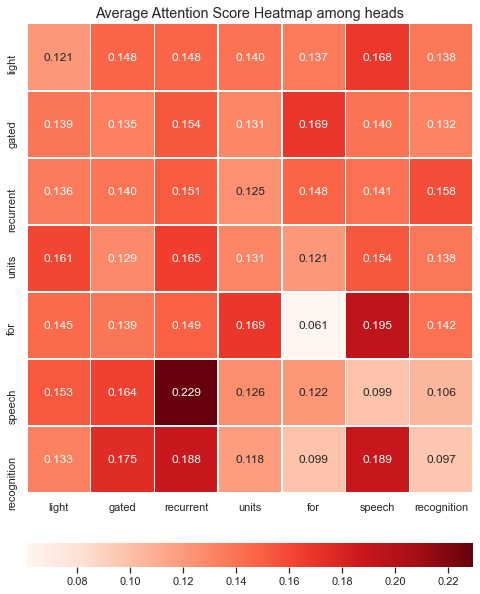

In [142]:
draw_heatmap(attn_avg_0, paper, title='Average Attention Score Heatmap among heads')

(<AxesSubplot:title={'center':'Average Attention Score Heatmap among heads'}>,
 <AxesSubplot:>)

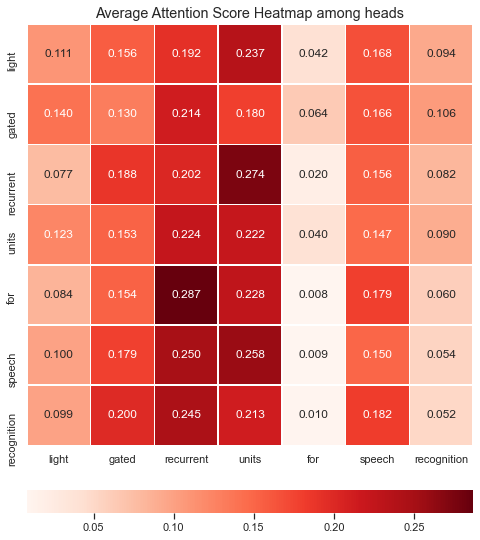

In [129]:
draw_heatmap(attn_avg_1, paper, title='Average Attention Score Heatmap among heads')

(<AxesSubplot:title={'center':'Average Attention Score Heatmap among heads'}>,
 <AxesSubplot:>)

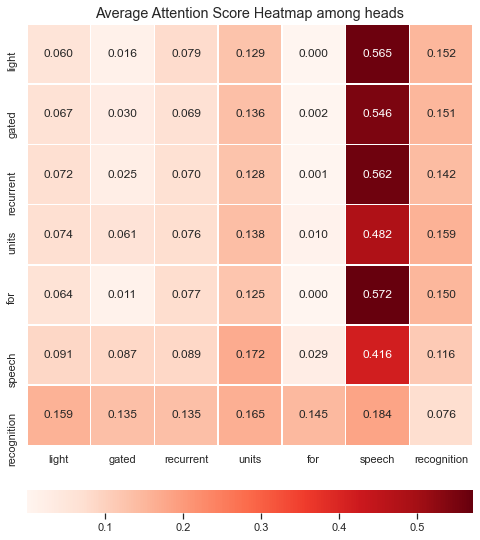

In [130]:
draw_heatmap(attn_avg_2, paper, title='Average Attention Score Heatmap among heads')

(<AxesSubplot:title={'center':'Average Attention Score Heatmap among heads'}>,
 <AxesSubplot:>)

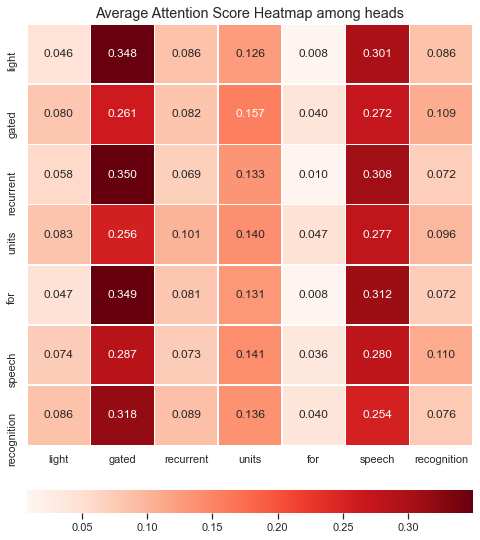

In [131]:
draw_heatmap(attn_avg_3, paper, title='Average Attention Score Heatmap among heads')

(<AxesSubplot:title={'center':'Attention Score Heatmap'}>, <AxesSubplot:>)

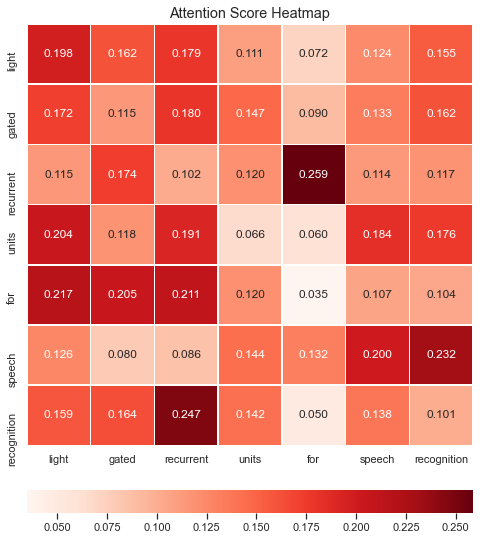

In [115]:
draw_heatmap(attn_filtered(attn, 0, 0, last_idx), paper)

(<AxesSubplot:title={'center':'Attention Score Heatmap'}>, <AxesSubplot:>)

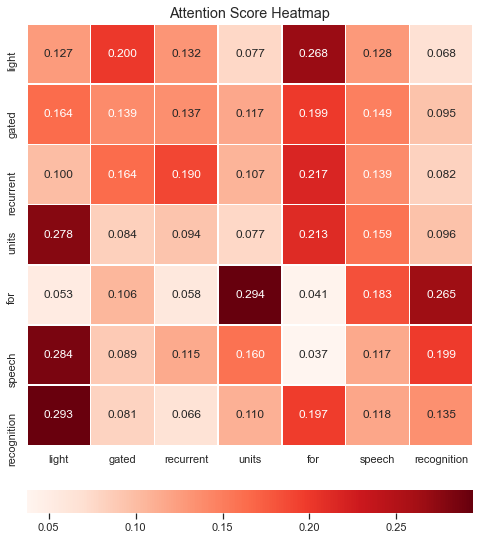

In [116]:
draw_heatmap(attn_filtered(attn, 0, 1, last_idx), paper)

(<AxesSubplot:title={'center':'Attention Score Heatmap'}>, <AxesSubplot:>)

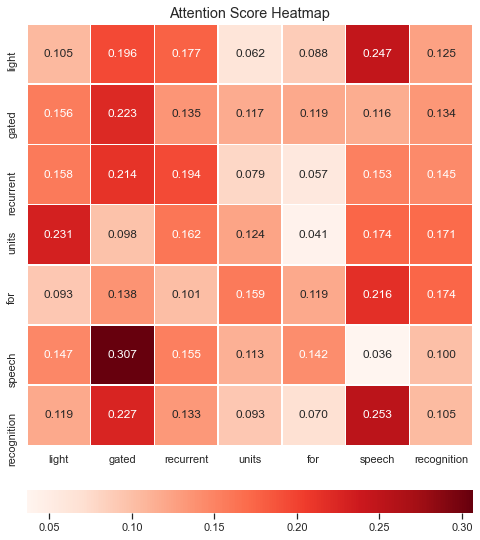

In [117]:
draw_heatmap(attn_filtered(attn, 0, 2, last_idx), paper)

(<AxesSubplot:title={'center':'Attention Score Heatmap'}>, <AxesSubplot:>)

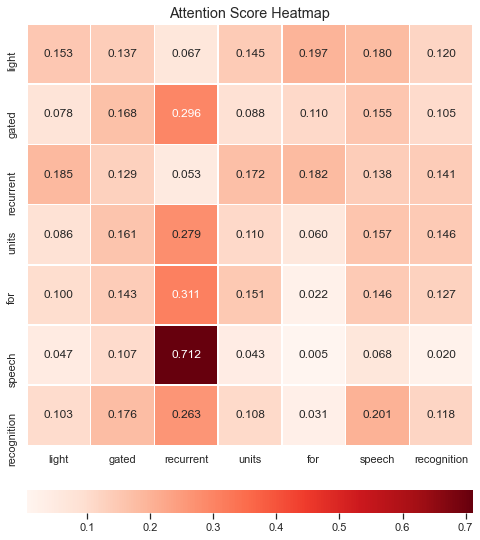

In [118]:
draw_heatmap(attn_filtered(attn, 0, 3, last_idx), paper)

# SOME EDA CODES FOR PPT

In [36]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', palette='Reds_r')

from paperswithtopic.dataloader import get_dataloader

In [22]:
cfg = load_config()
cfg.use_saved = True
cfg.pre_embed = False
cfg.use_bert_embed = False

cfg.drop = []

In [23]:
preprocess = Preprocess(cfg=cfg)
X, y = preprocess.pp_pipeline()
idx2word = preprocess.idx2word

[load_data] 0.3 sec 
There are 49980 papers.
[retrieve_raw_papers] 0.0 sec 
[remove_unknown] 0.3 sec 
[build_idx2word] 21.9 sec 
[tokenize_papers] 0.3 sec 
[pp_pipeline] 22.9 sec 


In [25]:
train_dataloader = get_dataloader(cfg, X, y, test=False, shuffle=True)
valid_dataloader = get_dataloader(cfg, X, y, test=True)

In [26]:
train_labels = train_dataloader.dataset.label
valid_labels = valid_dataloader.dataset.label

In [28]:
 train_labels = pd.Series(Counter(np.where(train_labels == 1)[1]))
valid_labels = pd.Series(Counter(np.where(valid_labels == 1)[1]))

In [29]:
dist = pd.DataFrame(
[train_labels, valid_labels], index=['Train', 'Valid']).T

In [42]:
column2idx = load_config('./data/column2idx.yml')
column2idx = {v: k for k, v in column2idx.items()}

Text(0, 0.5, 'Proportion (%)')

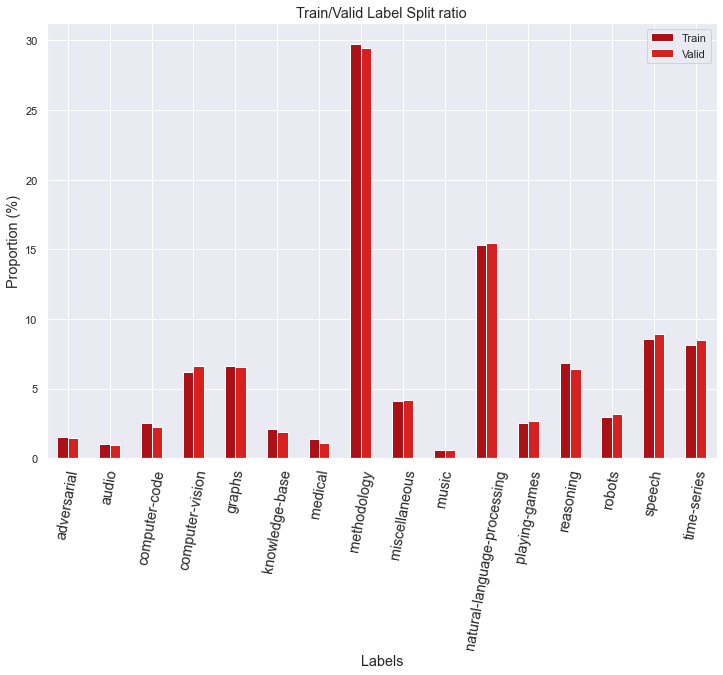

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))
(dist / dist.sum(axis=0) * 100).plot(kind='bar', ax=ax)
ax.set_title('Train/Valid Label Split ratio', size='large')
ax.set_xlabel('Labels', size='large')
ax.set_xticklabels(list(column2idx.values()), rotation=80, size='large')
ax.set_ylabel('Proportion (%)', size='large')